In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import numpy as np
import os
import time
import json
from PIL import Image


In [ ]:
annotation_zip = tf.keras.utils.get_file('captions.zip',
                                         cache_subdir=os.path.abspath('.'),
                                         origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                         extract=True)
annotation_file = os.path.dirname(annotation_zip) + '/annotations/captions_train2014.json'

name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
  image_zip = tf.keras.utils.get_file(name_of_zip,
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + '/train2014/'
else:
  PATH = os.path.abspath('.') + '/train2014/'


13510582272/13510573713 [==============================] - 156s 0us/step


In [ ]:
with open(annotation_file, 'r') as f:
  annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
  caption = '<start> ' + annot['caption'] + ' <end>'
  image_id = annot['image_id']
  full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % image_id

  all_img_name_vector.append(full_coco_image_path)
  all_captions.append(caption)


train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)
num_examples = 20000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]


In [ ]:
len(train_captions), len(all_captions)


(20000, 414113)

In [ ]:
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
!pip install tqdm

In [ ]:
from tqdm import tqdm

In [ ]:
encode_train = sorted(set(img_name_vector))

In [ ]:
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 1136/1136 [1:17:57<00:00,  4.12s/it]


In [ ]:
def calc_max_length(tensor):
  return max(len(t) for t in tensor)

In [ ]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


In [ ]:
max_length = calc_max_length(train_seqs)


In [ ]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)


(16000, 16000, 4000, 4000)

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dim = 256 
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8') + '.npy')
  return img_tensor, cap


dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
  map_func, [item1, item2], [tf.float32, tf.int32]),
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
 
  def __init__(self, embedding_dim):
    super(CNN_Encoder, self).__init__()
    self.fc = tf.keras.layers.Dense(embedding_dim)

  def call(self, x):
    x = self.fc(x)
    x = tf.nn.relu(x)
    return x




In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
  from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])


In [ ]:
loss_plot = []


In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
      # passing the features through the decoder
      predictions, hidden, _ = decoder(dec_input, features, hidden)

      loss += loss_function(target[:, i], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss


In [ ]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
  start = time.time()
  total_loss = 0

  for (batch, (img_tensor, target)) in enumerate(dataset):
    batch_loss, total_loss = train_step(img_tensor, target)
    total_loss += total_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(
        epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
  # storing the epoch end loss value to plot later  n
  loss_plot.append(total_loss / num_steps)

  if epoch % 5 == 0:
    ckpt_manager.save()

  print('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                      total_loss / num_steps))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 2.0024
Epoch 1 Batch 100 Loss 1.1899
Epoch 1 Batch 200 Loss 1.0659
Epoch 1 Batch 300 Loss 0.9079
Epoch 1 Batch 400 Loss 0.8496
Epoch 1 Loss 0.003134
Time taken for 1 epoch 2276.6725447177887 sec

Epoch 2 Batch 0 Loss 0.8457
Epoch 2 Batch 100 Loss 0.8631
Epoch 2 Batch 200 Loss 0.8053
Epoch 2 Batch 300 Loss 0.7630
Epoch 2 Batch 400 Loss 0.7788
Epoch 2 Loss 0.002759
Time taken for 1 epoch 2170.6453092098236 sec

Epoch 3 Batch 0 Loss 0.6804
Epoch 3 Batch 100 Loss 0.8336
Epoch 3 Batch 200 Loss 0.7471
Epoch 3 Batch 300 Loss 0.7899
Epoch 3 Batch 400 Loss 0.7891
Epoch 3 Loss 0.002708
Time taken for 1 epoch 2162.7638370990753 sec

Epoch 4 Batch 0 Loss 0.6613
Epoch 4 Batch 100 Loss 0.6611
Epoch 4 Batch 200 Loss 0.6677
Epoch 4 Batch 300 Loss 0.7558
Epoch 4 Batch 400 Loss 0.7467
Epoch 4 Loss 0.002634
Time taken for 1 epoch 2241.941582918167 sec

Epoch 5 Batch 0 Loss 0.7178
Epoch 5 Batch 100 Loss 0.6608
Epoch 5 Batch 200 Loss 0.5765
Epoch 5 Batch 300 Loss 0.5948
Epoch 5 Batch 4

KeyboardInterrupt: ignored

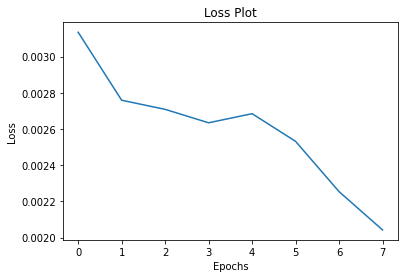

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
  attention_plot = np.zeros((max_length, attention_features_shape))

  hidden = decoder.reset_state(batch_size=1)

  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

  features = encoder(img_tensor_val)

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
  result = []

  for i in range(max_length):
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

    attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()
    result.append(tokenizer.index_word[predicted_id])

    if tokenizer.index_word[predicted_id] == '<end>':
      return result, attention_plot

    dec_input = tf.expand_dims([predicted_id], 0)

  attention_plot = attention_plot[:len(result), :]
  return result, attention_plot


In [ ]:
def plot_attention(image, result, attention_plot):
  temp_image = np.array(Image.open(image))

  fig = plt.figure(figsize=(10, 10))

  len_result = len(result)
  for l in range(len_result):
    temp_att = np.resize(attention_plot[l], (8, 8))
    ax = fig.add_subplot(len_result // 2, len_result // 2, l + 1)
    ax.set_title(result[l])
    img = ax.imshow(temp_image)
    ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

  plt.tight_layout()
  plt.show()

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

Real Caption: <start> a cat that is sitting down on a chair <end>
Prediction Caption: a cat sitting on the floor <end>


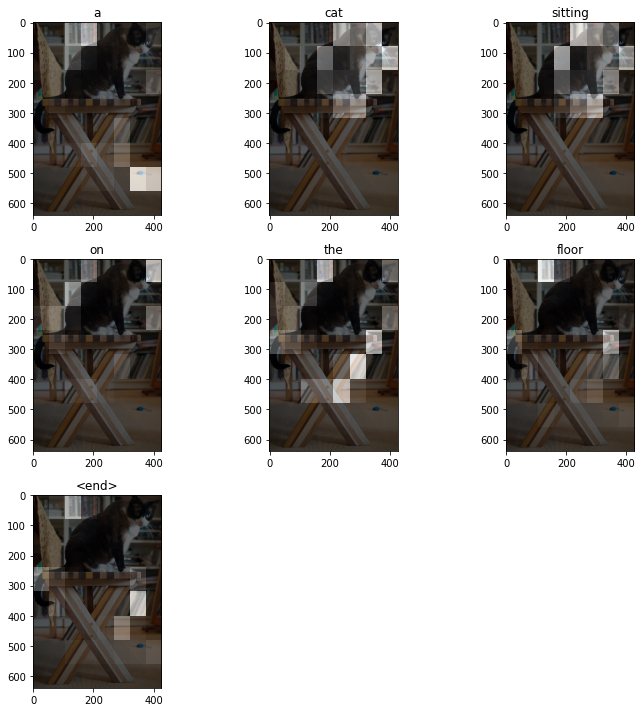

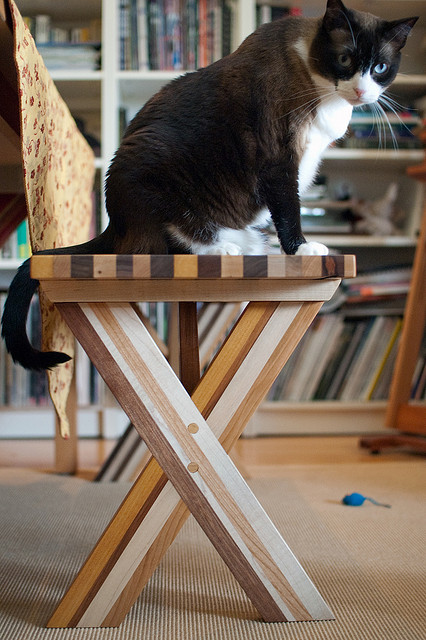

In [ ]:
print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])